In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
%matplotlib inline

tf.set_random_seed(777)  # reproducibility

In [2]:
def MinMaxScaler(data):
    ''' Min Max Normalization
    Parameters
    ----------
    data : numpy.ndarray
        input data to be normalized
        shape: [Batch size, dimension]
    Returns
    ----------
    data : numpy.ndarry
        normalized data
        shape: [Batch size, dimension]
    References
    ----------
    .. [1] http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
    '''
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

In [3]:
# train Parameters
seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

In [4]:
# Open, High, Low, Volume, Close
xy = np.loadtxt('data-02-stock_daily.csv', delimiter=',')
xy = xy[::-1]  # reverse order (chronically ordered)
xy = MinMaxScaler(xy)
x = xy
y = xy[:, [-1]]  # Close as label

In [5]:
# build a dataset
dataX = []
dataY = []
for i in range(0, len(y) - seq_length):
    _x = x[i:i + seq_length]
    _y = y[i + seq_length]  # Next close price
    print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)

[[  2.13751054e-01   2.08179810e-01   1.91791832e-01   4.66075110e-04
    1.92092403e-01]
 [  1.93935034e-01   2.03641926e-01   2.08664571e-01   2.98467330e-03
    1.96551555e-01]
 [  2.10516454e-01   2.05289413e-01   2.03558748e-01   2.59926504e-04
    1.87749731e-01]
 [  1.86678765e-01   2.09480567e-01   2.08781843e-01   0.00000000e+00
    2.17448151e-01]
 [  3.06973882e-01   3.14634137e-01   2.18993665e-01   1.24764722e-02
    2.16981885e-01]
 [  2.19142110e-01   2.63907214e-01   2.24686396e-01   4.56323384e-01
    2.24967473e-01]
 [  2.33129931e-01   2.36419163e-01   1.62682724e-01   5.70171193e-01
    1.47442742e-01]] -> [ 0.13289962]
[[  1.93935034e-01   2.03641926e-01   2.08664571e-01   2.98467330e-03
    1.96551555e-01]
 [  2.10516454e-01   2.05289413e-01   2.03558748e-01   2.59926504e-04
    1.87749731e-01]
 [  1.86678765e-01   2.09480567e-01   2.08781843e-01   0.00000000e+00
    2.17448151e-01]
 [  3.06973882e-01   3.14634137e-01   2.18993665e-01   1.24764722e-02
    2.169818

In [6]:
# train/test split
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(
    dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(
    dataY[train_size:len(dataY)])

In [7]:
# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

In [8]:
# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output

In [9]:
# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

In [10]:
# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

[step: 0] loss: 83.71253967285156
[step: 1] loss: 40.165771484375
[step: 2] loss: 14.83617115020752
[step: 3] loss: 4.34723424911499
[step: 4] loss: 4.6733808517456055
[step: 5] loss: 10.14285945892334
[step: 6] loss: 14.430902481079102
[step: 7] loss: 14.795209884643555
[step: 8] loss: 12.097990036010742
[step: 9] loss: 8.227913856506348
[step: 10] loss: 4.723766803741455
[step: 11] loss: 2.4249753952026367
[step: 12] loss: 1.5312610864639282
[step: 13] loss: 1.793663501739502
[step: 14] loss: 2.7270965576171875
[step: 15] loss: 3.8031868934631348
[step: 16] loss: 4.602985858917236
[step: 17] loss: 4.9007086753845215
[step: 18] loss: 4.6666083335876465
[step: 19] loss: 4.016658306121826
[step: 20] loss: 3.1457417011260986
[step: 21] loss: 2.265700340270996
[step: 22] loss: 1.5562686920166016
[step: 23] loss: 1.1312130689620972
[step: 24] loss: 1.0211440324783325
[step: 25] loss: 1.1748931407928467
[step: 26] loss: 1.4803638458251953
[step: 27] loss: 1.8013248443603516
[step: 28] loss:

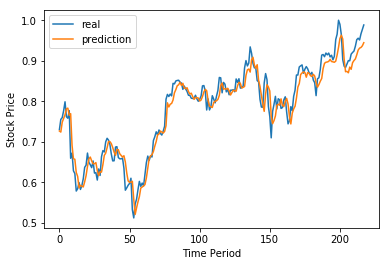

In [11]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))
    
    # Plot predictions
    plt.plot(testY)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.legend(['real', 'prediction'])
    plt.show()